# Speaker classifier 
Using Keras and [free-spoken-digit-dataset](https://github.com/Jakobovski/free-spoken-digit-dataset)

## Loading data and Preprocessing

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn import model_selection

In [2]:
# load wav data
def load_wav(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, sr = librosa.load(file_path)
    return x, sr

# convert wav data to melspectrogram
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft, ref=np.max)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# plot wave
def show_wav(x):
    plt.plot(x)
    plt.show()

# wave in heatmap
def show_melsp(melsp, sr):
    librosa.display.specshow(melsp, sr=sr)
    plt.colorbar()
    plt.show()

### Show sample data

wave size:(13029,)
melsp size:(128, 102)
sampling rate:22050


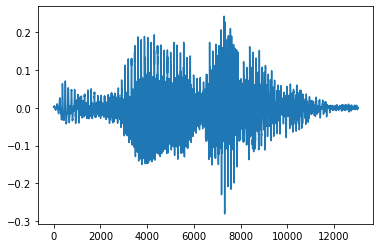

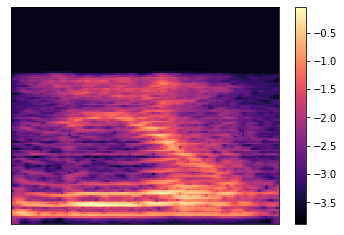

In [3]:
x, sr = load_wav('free-spoken-digit-dataset/recordings/','0_george_1.wav')
melsp = calculate_melsp(x)
print(f'wave size:{x.shape}\nmelsp size:{melsp.shape}\nsampling rate:{sr}')
show_wav(x)
show_melsp(melsp, sr)

### Get filenames and label all of them (one-hot)

In [4]:
# X ==> file names
# label ==> one-hot matrix by name
X = []
label = []
people = ['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler']
audio_dir = "/home/keisuke/code/python3/smart-speaker/free-spoken-digit-dataset/recordings/"
path_list = os.listdir(audio_dir)

i = 0
for name in people:
    for path in path_list:
        matrix = [0,0,0,0,0,0]
        if path.find(name) != -1:
            X.append(path)
            matrix[i]+=1
            label.append(matrix)
    i+= 1
X = np.array(X)
label = np.array(label)

### Split data in train and test

In [5]:
x_train_fn, x_test_fn, y_train, y_test = model_selection.train_test_split(X, label, test_size=0.25, stratify=label, shuffle=True)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train_fn),
                                                                len(y_train), 
                                                                len(x_test_fn), 
                                                                len(y_test)))

x train:2250
y train:2250
x test:750
y test:750


### Fix every length to the same length

In [6]:
# find max length
def get_max_length(data):
    list_len = [len(i) for i in data]
    max_length = max(list_len)
    print(f'MAX:{max_length}')
    return max_length

# get audio data and and wrap in []
def get_wavs(x):
    data = []
    for i in range(len(x)):
        _x, sr = load_wav(audio_dir,x[i])
        data.append(_x)
    return data

# set same length to every records
def fix_length(data, max_length):
    tmp_array = []
    if len(data) != max_length:
        for i in range(len(data)):
            add_length = max_length - len(data[i])
            data[i] = np.append(data[i], np.zeros(add_length))
    return data

def get_melsp(data):
    for i in range(len(data)):
        data[i] = calculate_melsp(data[i])
    return data

In [7]:
# get the max length
data = get_wavs(X)
max_length = get_max_length(data)

MAX:50335


### Save the train/test data as np.

In [8]:
# train_data
if not os.path.exists("train.npz"):
    data = get_wavs(x_train_fn)
    data = fix_length(data, max_length)
    data = get_melsp(data)
    print(f'TRAIN shape: {np.array(data).shape}')
    np.savez("train.npz", x=np.array(data), y=y_train)

# test_data
if not os.path.exists("test.npz"):
    data = get_wavs(x_test_fn)
    data = fix_length(data, max_length)
    data = get_melsp(data)
    print(f'TEST shape: {np.array(data).shape}')
    np.savez("test.npz", x=np.array(data), y=y_test)

### Data expantion

In [9]:
# add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# timeshift
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# stretch
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [10]:
# train_data with white noise
if not os.path.exists("train_white_noise.npz"):
    data = get_wavs(x_train_fn)
    data = fix_length(data, max_length)
    for i in range(len(data)):
        data[i] = add_white_noise(data[i])
    data = get_melsp(data)
    np.savez("train_white_noise.npz", x=np.array(data), y=y_train)
    
# timeshifted train_data
if not os.path.exists("train_timeshift.npz"):
    data = get_wavs(x_train_fn)
    data = fix_length(data, max_length)
    for i in range(len(data)):
        data[i] = add_white_noise(data[i])
    data = get_melsp(data)
    np.savez("train_timeshif.npz", x=np.array(data), y=y_train)
    
# stretched train_data
if not os.path.exists("train_stretch.npz"):
    data = get_wavs(x_train_fn)
    data = fix_length(data, max_length)
    for i in range(len(data)):
        data[i] = stretch_sound(data[i])
    data = get_melsp(data)
    np.savez("train_stretch.npz", x=np.array(data), y=y_train)

## Deep Learning with CNN

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [12]:
def get_model(shape):
    model = models.Sequential()
    model.add(layers.Reshape((shape[0], shape[1], 1),
                             input_shape=(shape[0], shape[1])))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))
    
    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
data = np.load('train.npz')
x_train = data["x"]
y_train = data["y"]

data = np.load('train_white_noise.npz')
x_train = np.append(x_train,data["x"], axis=0)
y_train = np.append(y_train,data["y"], axis=0)

data = np.load('test.npz')
x_test = data["x"]
y_test = data["y"]

In [14]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(4500, 128, 394) (750, 128, 394)
(4500, 6) (750, 6)


In [15]:
# Train model
model = get_model([128, 394])
model.fit(x_train, y_train, epochs=50, shuffle=True)

2021-11-14 00:51:13.367211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 00:51:13.371965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 00:51:13.372281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 00:51:13.372789: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/50


2021-11-14 00:51:15.325083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


141/141 [==============================] - 10s 53ms/step - loss: 2.1630 - accuracy: 0.1671
Epoch 2/50
141/141 [==============================] - 7s 48ms/step - loss: 1.7320 - accuracy: 0.2353
Epoch 3/50
141/141 [==============================] - 7s 48ms/step - loss: 0.7974 - accuracy: 0.6920
Epoch 4/50
141/141 [==============================] - 7s 48ms/step - loss: 0.2392 - accuracy: 0.9156
Epoch 5/50
141/141 [==============================] - 7s 48ms/step - loss: 0.0686 - accuracy: 0.9798
Epoch 6/50
141/141 [==============================] - 7s 48ms/step - loss: 0.0259 - accuracy: 0.9927
Epoch 7/50
141/141 [==============================] - 7s 48ms/step - loss: 0.0255 - accuracy: 0.9927
Epoch 8/50
141/141 [==============================] - 7s 48ms/step - loss: 0.0055 - accuracy: 0.9989
Epoch 9/50
141/141 [==============================] - 7s 48ms/step - loss: 0.0027 - accuracy: 0.9998
Epoch 10/50
141/141 [==============================] - 7s 48ms/step - loss: 0.0014 - accuracy: 0.9998

In [16]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

24/24 [==============================] - 1s 30ms/step - loss: 0.0178 - accuracy: 0.9947
Test loss: 0.017828218638896942
Test accuracy: 0.9946666955947876


<AxesSubplot:>

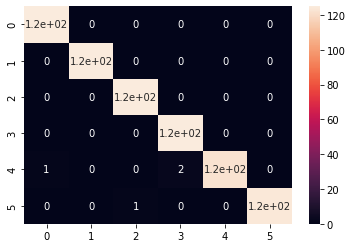

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)